## **Load the Dataset from kaggle**

In [1]:
!pip install -q kagglehub


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import os
import kagglehub
from PIL import Image
import matplotlib.pyplot as plt

# Download dataset
# path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")


In [4]:
path = r'./Dataset'

# Handle possible nesting
if os.path.isdir(path) and len(os.listdir(path)) == 1:
    inner_folder = os.path.join(path, os.listdir(path)[0])
else:
    inner_folder = path

# Construct paths for Train/Real and Train/Fake
train_real = os.path.join(inner_folder, "Train", "Real")
train_fake = os.path.join(inner_folder, "Train", "Fake")



Displaying Real Images:


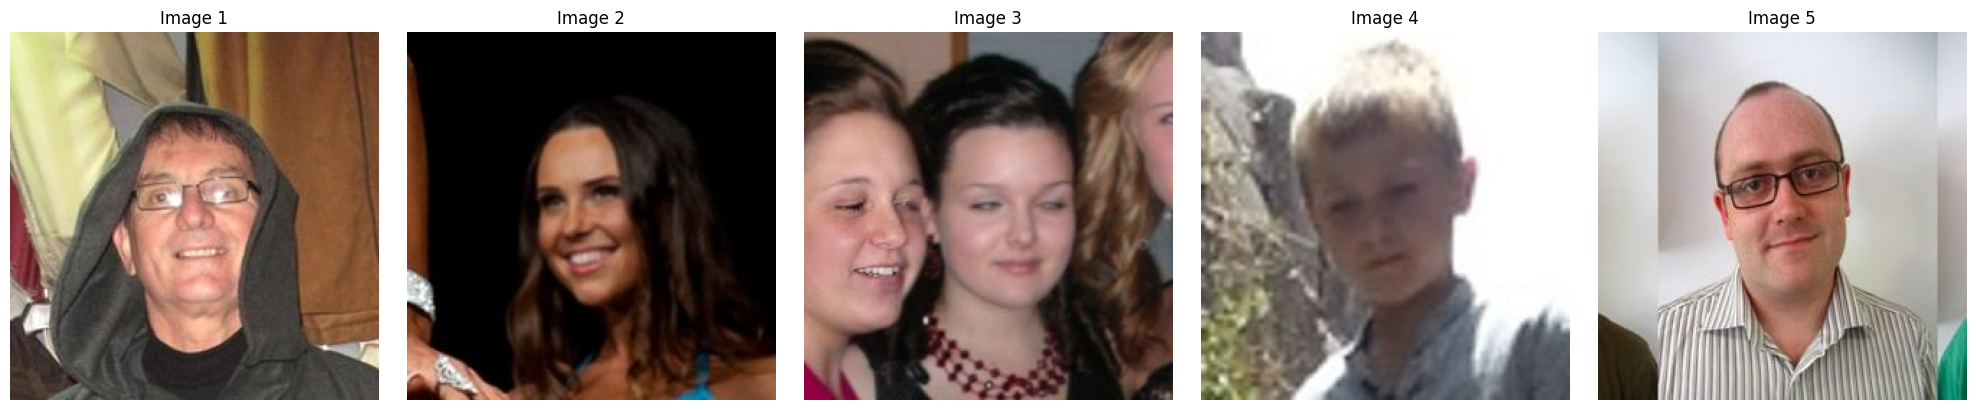


Displaying Fake Images:


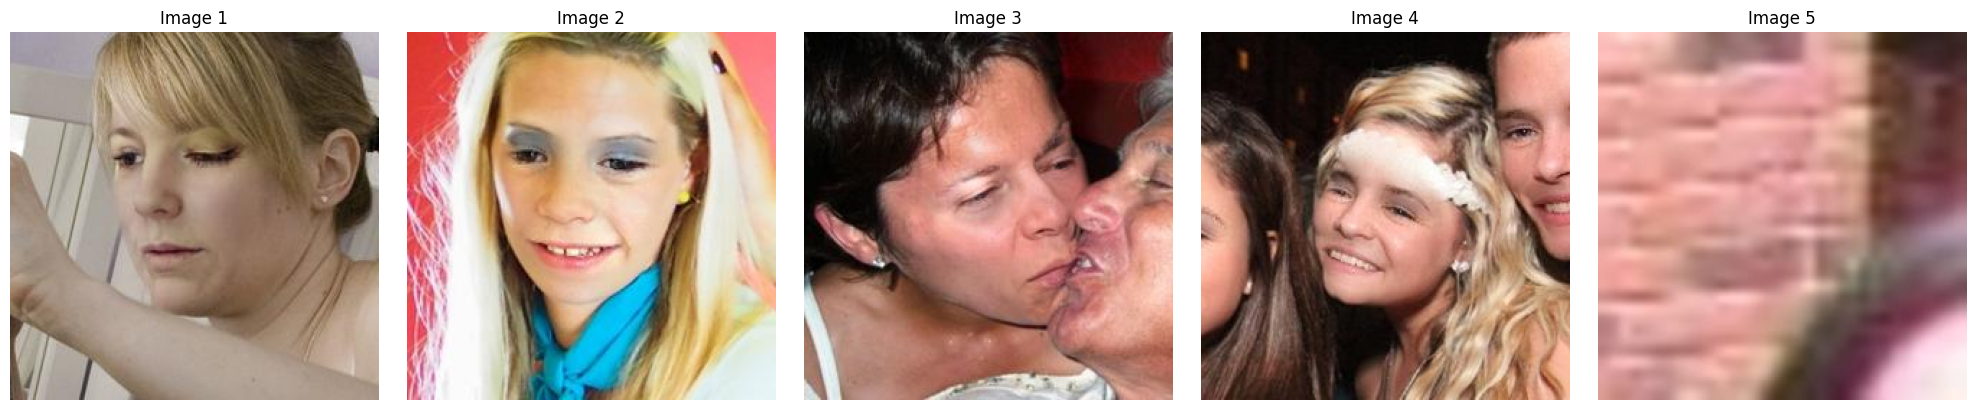

In [5]:
# Function to display images
def display_images(folder_path, num_images=5):
    """
    Displays a specified number of images from the given folder.
    """
    image_files = os.listdir(folder_path)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))

    for i, img_file in enumerate(image_files):
        img_path = os.path.join(folder_path, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

# Display images from Train/Real
print("\nDisplaying Real Images:")
display_images(train_real)

# Display images from Train/Fake
print("\nDisplaying Fake Images:")
display_images(train_fake)

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import img_to_array, load_img


train_dir = os.path.join(inner_folder, "Train")
val_dir = os.path.join(inner_folder, "Validation")
test_dir = os.path.join(inner_folder, "Test")

# Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
PERCENTAGE_TO_USE = 0.6 


def get_dataset_from_dir(directory, percentage=0.6, seed=42):
    all_real = tf.io.gfile.listdir(os.path.join(directory, "Real"))
    all_fake = tf.io.gfile.listdir(os.path.join(directory, "Fake"))


    real_count = int(len(all_real) * percentage)
    fake_count = int(len(all_fake) * percentage)

    real_samples = np.random.choice(all_real, size=real_count, replace=False)
    fake_samples = np.random.choice(all_fake, size=fake_count, replace=False)

    real_paths = [os.path.join(directory, "Real", fname) for fname in real_samples]
    fake_paths = [os.path.join(directory, "Fake", fname) for fname in fake_samples]

    image_paths = real_paths + fake_paths
    labels = [1] * len(real_paths) + [0] * len(fake_paths)  # 1 = Real, 0 = Fake


    rng = np.random.default_rng(seed=seed)
    indices = np.arange(len(image_paths))
    rng.shuffle(indices)

    image_paths = np.array(image_paths)[indices]
    labels = np.array(labels)[indices]

    return image_paths, labels


def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255.0  # Normalize to [0,1]
    return img, label


def create_dataset(directory, batch_size=BATCH_SIZE, percentage=0.6):
    file_paths, labels = get_dataset_from_dir(directory, percentage)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


train_dataset = create_dataset(train_dir, BATCH_SIZE, PERCENTAGE_TO_USE)
val_dataset = create_dataset(val_dir, BATCH_SIZE, PERCENTAGE_TO_USE)
test_dataset = create_dataset(test_dir, BATCH_SIZE, PERCENTAGE_TO_USE)

print("\nDatasets created successfully.")


Datasets created successfully.


In [7]:
import os

#  Force CPU mode
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Disable OneDNN warnings
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Reduce shuffle buffer
SHUFFLE_BUFFER_SIZE = 100
BATCH_SIZE = 16

# Use disk-based caching and reduced shuffle
train_dataset = train_dataset.cache("train_cache").shuffle(SHUFFLE_BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache("val_cache").prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## **Preprocssing**

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models


IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32


def preprocess_datasets(train_dataset, val_dataset, test_dataset):
    
    preprocessing_layers = tf.keras.Sequential([
        layers.Rescaling(1./255),  # Normalize to [0,1]

        # Optional Augmentation (helps prevent overfitting)
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
    ])

    train_dataset = train_dataset.map(lambda x, y: (preprocessing_layers(x, training=True), y),
                                      num_parallel_calls=tf.data.AUTOTUNE)

    val_dataset = val_dataset.map(lambda x, y: (layers.Rescaling(1./255)(x), y),
                                  num_parallel_calls=tf.data.AUTOTUNE)

    test_dataset = test_dataset.map(lambda x, y: (layers.Rescaling(1./255)(x), y),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_dataset = val_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset, val_dataset, test_dataset = preprocess_datasets(
    train_dataset, val_dataset, test_dataset
)

## **Visualization Sample**

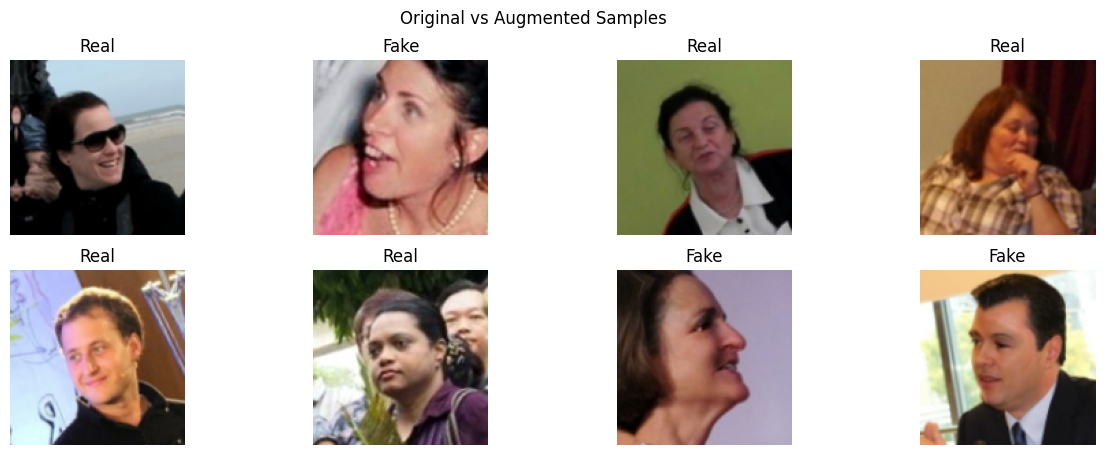

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch from train dataset
for images, labels in train_dataset.take(1):
    images = images.numpy()
    labels = labels.numpy()

# Function to plot images
def plot_images(images, labels, title="Images"):
    plt.figure(figsize=(15, 5))
    for i in range(8):  # Show 8 images
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        plt.title("Real" if labels[i] > 0.5 else "Fake")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Plot original vs augmented
plot_images(images, labels, title="Original vs Augmented Samples")

In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



c:\Users\abdullah\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
# Train the model
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5


: 

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test dataset
test_results = model.evaluate(test_dataset)
print(f"\nTest Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    preds = model.predict(images).flatten()
    y_pred.extend((preds > 0.5).astype(int))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, callbacks

# Image size for MobileNetV2 input (min is 32x32, but we'll use 128)
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model to prevent its weights from updating during training
base_model.trainable = False

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Regularization
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [25]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model.keras',  # Save in Keras format
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=10, 
    validation_data=val_dataset,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
 128/2625 ━━━━━━━━━━━━━━━━━━━━ 14:28 348ms/step - accuracy: 0.4887 - loss: 0.7280

: 

In [ ]:
# Reload the best model
best_model = models.load_model('best_model.keras')

# Evaluate on test dataset
test_results = best_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_results[0]:.4f}, Test Accuracy: {test_results[1]:.4f}")

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Collect true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())
    preds = best_model.predict(images).flatten()
    y_pred.extend((preds > 0.5).astype(int))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"]))

In [2]:
# Save the final best model
best_model.save("deepfake_classifier.keras")
print("✅ Model saved as 'deepfake_classifier.keras'")

NameError: name 'best_model' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Load saved model
best_model = load_model("best_model.keras")

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array

def predict_image(image_path, model, image_size=(128, 128)):
\
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB").resize(image_size)
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension

    # Make prediction
    prediction = model.predict(image_array)[0][0]

    # Display image
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {'Real' if prediction > 0.5 else 'Fake'} (Confidence: {prediction:.4f})")
    plt.show()

    return "Real" if prediction > 0.5 else "Fake"

In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr

# Define Gradio wrapper
def classify_image(image):
    # Convert PIL image to array and resize
    image = image.resize((128, 128))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Predict
    prediction = best_model.predict(image_array)[0][0]
    label = "Real" if prediction > 0.5 else "Fake"
    confidence = float(prediction) if label == "Real" else 1.0 - float(prediction)

    return {
        "Label": label,
        "Confidence": confidence
    }

# Create Gradio interface
image_input = gr.Image(type="pil", label="Upload an Image")
output_label = gr.Label(num_top_classes=2)

gr.Interface(
    fn=classify_image,
    inputs=image_input,
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Number(label="Confidence Score")
    ],
    title="Deepfake vs Real Image Classifier",
    description="Upload an image to check if it's real or fake using a CNN model.",
    examples=[
        ["test_real_1.jpg"],
        ["test_fake_1.jpg"]
    ]
).launch()

In [ ]:
from google.colab import files

uploaded = files.upload()  # Upload one or more test images
for fname in uploaded.keys():
    print(f"Uploaded file: {fname}")